# Data Exploration

The data provided for this challenge is divided in the following manner:

 + Training set: 50,000 samples
 + Validation set: 50,000 samples
 + Test set: 100,000 samples

There are 1,000 possible labels, and each image can have up to 5 objects in it.

### Sample images

In [1]:
sample_images_path = 'sample-images/'
sample_images = ['n01440764_5647.JPEG', 'n01774750_8125.JPEG', 'n04447861_3133.JPEG', 'n02091134_7845.JPEG']

In [2]:
from IPython.display import display, HTML

html = ["<td><img src='{}' /></td>".format(sample_images_path + img) for img in sample_images]
display(HTML("<table><tr>{}</tr></table>".format(''.join(html))))

,,,


### Labels

The training an validation sets are labeled such that each sample image contains zero (none) or more (up to five) bounding boxes describing where the object is in the image, as well as what that object is. Each sample is labeled in the following format:

 + ImageId - the ID of the sample image
 + Width - width of the image (in pixels)
 + Height - height of the image (in pixels)
 + PredictionString - a set of zero of more groups of five values, representing:
     + synsetId - the synset ID of the object in the image
     + x_min - left coordinate of the top left corner (in pixels) of the bounding box where the object in the image
     + y_min - top coordinate of the top left corner (in pixels) of the bounding box where the object in the
     + x_max - right coordinate of the bottom right corner (in pixels) of the bounding box where the object in the image
     + y_max - bottom coordinate of the bottom right corner (in pixels) of the bounding box where the object in the

In [3]:
import pandas as pd

In [4]:
loc_train_solution = pd.read_csv('LOC_train_solution_with_size.csv')
loc_val_solution = pd.read_csv('LOC_val_solution_with_size.csv')
loc_synset_mapping_path = 'LOC_synset_mapping.txt'

In [5]:
loc_train_solution.head()

,ImageId,Width,Height,PredictionString
0,n02017213_7894,500,334,n02017213 115 49 448 294
1,n02017213_7261,400,500,n02017213 91 42 330 432
2,n02017213_5636,500,341,n02017213 230 104 414 224
3,n02017213_6132,500,438,n02017213 46 82 464 387
4,n02017213_7659,333,500,n02017213 103 66 331 335


In [6]:
loc_val_solution.head()

,ImageId,Width,Height,PredictionString
0,ILSVRC2012_val_00048981,500,360,n03995372 85 1 499 272
1,ILSVRC2012_val_00037956,500,333,n03481172 131 0 499 254
2,ILSVRC2012_val_00026161,500,334,n02108000 38 0 464 280
3,ILSVRC2012_val_00026171,225,300,n03109150 0 14 216 299
4,ILSVRC2012_val_00008726,500,357,n02119789 255 142 454 329 n02119789 44 21 322 295


### Bounding boxes as percentages

Since we'll be using TensorFlow for this, we'll use [tf.image.draw_bounding_boxes](https://www.tensorflow.org/api_docs/python/tf/image/draw_bounding_boxes) to see the bounding boxes during training and at inference. Since that API requires the values for `[x_min, y_min, x_max, y_max]` to be floats in `[0.0, 1.0]` relative to the width and height of each image, we'll need to convert those values from absolute pixels to percentages.

In [245]:
def expand_prediction_cell(df, colname):
    """Expands all the space separated values in a column into separate columns.
    The assumption is that the column to be expanded is the right-most one.
    Also, since the 5 values being expanded are label, x min, y min, x max, y max,
    those groups will also be put under column names that represent that more explicitly.
    """
    df = df[df.columns[:-1]].join(df[colname].str.split(' ', expand=True))
    
    renamed_cols = list(df.columns[3:])
    labels = ['lb', 'xmin', 'ymin', 'xmax', 'ymax']

    for i in range(int(len(renamed_cols) / 5)):
        renamed_cols[i*5:i*5+5] = [lb + str(i) for lb in labels]
    
    df.columns=list(df.columns[0:3]) + renamed_cols
    return df

# n02017213_7894 500 334 115 49 448 294
#                        0.23 | 0.146706587 | 0.896 | 0.880239521
# n02017213_7261 400 500 91 42 330 432
def px_to_pct(df, cols=10):
    """Given a dataframe in the format described by expand_prediction_cell,
    convert each pixel value in each bounding box group to a percentage relative to the image size.
    For example, if the image width is 100px and the x-min value is 25, the new value will be 0.25,
    meaning that the x-min starts 25% from the left of the image."""
    for label in ['xmin', 'ymin', 'xmax', 'ymax']:
        for i in range(cols):
            lb = label + str(i)
            df[lb] = pd.to_numeric(df[lb], errors='coerce')
#             df[lb] = df[lb] / df['Width']
#             df.iloc[:, 4::5] = 23
#             df.iloc[:, 4::5] = df.iloc[:, 4::5].astype(int).div(df['Width'].astype(int), axis=0)
            df['xmin0']
    
    return df

In [252]:
loc_train_solution_xp = expand_prediction_cell(loc_train_solution, 'PredictionString')
# loc_train_solution_xp = px_to_pct(loc_train_solution_xp, int((len(loc_train_solution_xp.columns) - 3) / 5))

# This works. How to automate it?
loc_train_solution_xp.xmin0 = loc_train_solution_xp.xmin0.astype(int) / loc_train_solution_xp.Width.astype(int)
loc_train_solution_xp.ymin0 = loc_train_solution_xp.ymin0.astype(int) / loc_train_solution_xp.Height.astype(int)
loc_train_solution_xp.xmax0 = loc_train_solution_xp.xmax0.astype(int) / loc_train_solution_xp.Width.astype(int)
loc_train_solution_xp.ymax0 = loc_train_solution_xp.ymax0.astype(int) / loc_train_solution_xp.Height.astype(int)

print(loc_train_solution_xp.shape)
loc_train_solution_xp.head()

(7867, 48)


,ImageId,Width,Height,lb0,xmin0,ymin0,xmax0,ymax0,lb1,xmin1,...,lb7,xmin7,ymin7,xmax7,ymax7,lb8,xmin8,ymin8,xmax8,ymax8
0,n02017213_7894,500,334,n02017213,0.230000,0.146707,0.896000,0.880240,None,None,...,None,None,None,None,None,None,None,None,None,None
1,n02017213_7261,400,500,n02017213,0.227500,0.084000,0.825000,0.864000,None,None,...,None,None,None,None,None,None,None,None,None,None
2,n02017213_5636,500,341,n02017213,0.460000,0.304985,0.828000,0.656891,None,None,...,None,None,None,None,None,None,None,None,None,None
3,n02017213_6132,500,438,n02017213,0.092000,0.187215,0.928000,0.883562,None,None,...,None,None,None,None,None,None,None,None,None,None
4,n02017213_7659,333,500,n02017213,0.309309,0.132000,0.993994,0.670000,None,None,...,None,None,None,None,None,None,None,None,None,None


### Synset mapping

The labels above are synset IDs, which we'll want to map to the their corresponding English values. Using the function `parse_synset_mapping()`, we'll have a dict that maps the synset ID to a list of values for that synset. Also, since we'll need to convert each synset ID to an integer, we'll need to generate another map to help with that.

In [9]:
def parse_synset_mapping(path):
    """Parse the synset mapping file into a dictionary mapping <synset_id>:[<synonyms in English>]
    This assumes an input file formatted as:
        <synset_id> <category>, <synonym...>
    Example:
        n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
    """
    synset_map = {}
    with open(path, 'r') as fp:
        lines = fp.readlines()
        for line in lines:
            parts = line.split(' ')
            synset_map[parts[0]] = [label.strip() for label in ' '.join(parts[1:]).split(',')]
        return synset_map
    
def generate_synset_to_int_mapping(synset_mapping):
    synset_to_int_map = {}
    for index, (key, val) in enumerate(synset_mapping.items()):
        synset_to_int_map[key] = index
    return synset_to_int_map
    
def generate_int_to_synset_mapping(synset_mapping):
    int_to_synset_map = {}
    for index, (key, val) in enumerate(synset_mapping.items()):
        int_to_synset_map[index] = key
    return int_to_synset_map

In [10]:
synset_mapping = parse_synset_mapping(loc_synset_mapping_path)
synset_to_int = generate_synset_to_int_mapping(synset_mapping)
int_to_synset = generate_int_to_synset_mapping(synset_mapping)

In [11]:
len(synset_mapping)

1000

In [12]:
for index, (key, val) in enumerate(synset_mapping.items()):
    if (index > 5):
        break
    print('{} {}'.format(key, val))

n01440764 ['tench', 'Tinca tinca']
n01443537 ['goldfish', 'Carassius auratus']
n01484850 ['great white shark', 'white shark', 'man-eater', 'man-eating shark', 'Carcharodon carcharias']
n01491361 ['tiger shark', 'Galeocerdo cuvieri']
n01494475 ['hammerhead', 'hammerhead shark']
n01496331 ['electric ray', 'crampfish', 'numbfish', 'torpedo']


In [13]:
for index, (key, val) in enumerate(synset_to_int.items()):
    if (index > 5):
        break
    print('{} {}'.format(key, val))

n01440764 0
n01443537 1
n01484850 2
n01491361 3
n01494475 4
n01496331 5


In [14]:
for index, (key, val) in enumerate(int_to_synset.items()):
    if (index > 5):
        break
    print('{} {}'.format(key, val))

0 n01440764
1 n01443537
2 n01484850
3 n01491361
4 n01494475
5 n01496331


### Putting it all together

Now we're ready to draw some bounding boxes to ensure that the above transformations were done correctly.

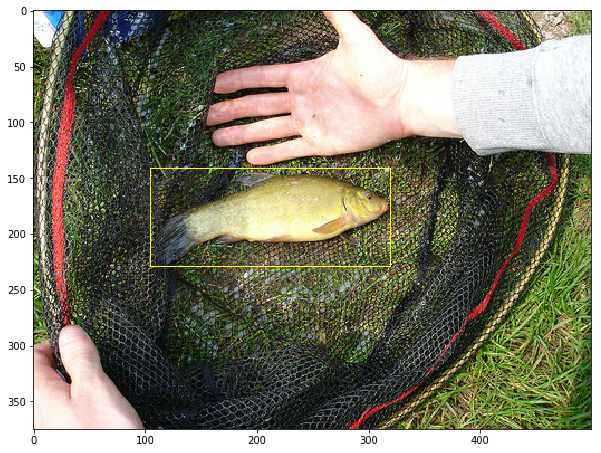

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_6/input_producer_6_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer_6, input_producer_6/RandomShuffle)]]


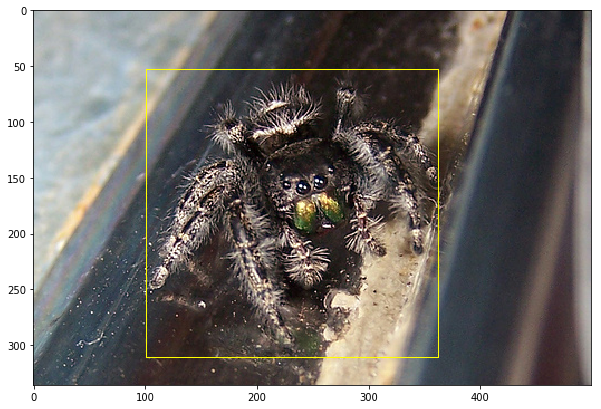

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_6/input_producer_6_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer_6, input_producer_6/RandomShuffle)]]


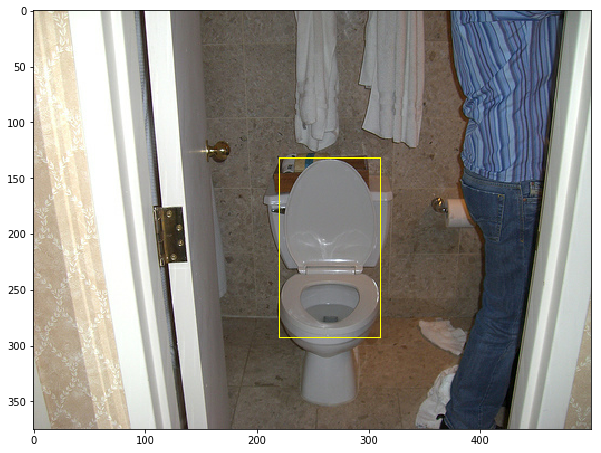

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_10/input_producer_10_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer_10, input_producer_10/RandomShuffle)]]


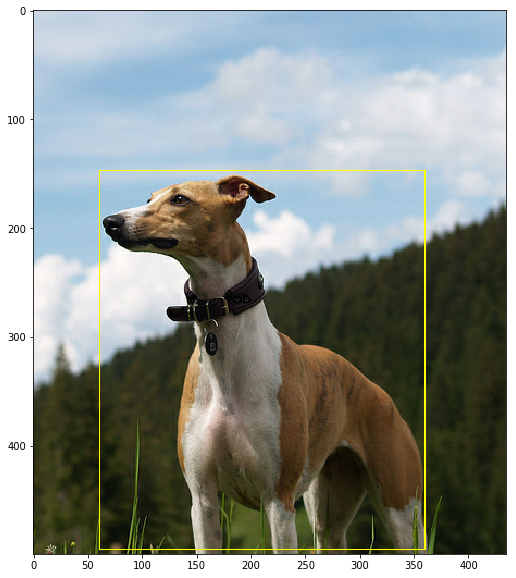

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_5/input_producer_5_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer_5, input_producer_5/RandomShuffle)]]


In [255]:
import tensorflow as tf
import matplotlib.pyplot as plt

def draw(sample_images_path, sample_img):
    xmin, ymin, xmax, ymax = [106, 142, 321, 230]
    size = [500, 375]
    
    img_path = sample_images_path + sample_img
    filename = sample_img.split('.')[0]
    row = loc_train_solution_xp.loc[loc_train_solution_xp['ImageId'] == filename]
    synset = row.ImageId.values[0].split('_')[0]
    
#     print(row[['ImageId', 'Width', 'Height', 'xmin0', 'ymin0', 'xmax0', 'ymax0']])
#     return
#     print('img_path: {}, filename: {}, row: {}, synset: {}'.format(img_path, filename, row.ymin0.values[0], synset))

    img_name = [img_path]
    filename_queue = tf.train.string_input_producer(img_name)
    img_reader = tf.WholeFileReader()
    _,image_jpg = img_reader.read(filename_queue)

    image_decode_jpeg = tf.image.decode_jpeg(image_jpg)
    image_decode_jpeg = tf.image.convert_image_dtype(image_decode_jpeg, dtype=tf.float32)
    img = image_decode_jpeg
    image_decode_jpeg = tf.expand_dims(image_decode_jpeg, 0)

    sess = tf.Session()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    box = tf.constant([[[row.ymin0.values[0], row.xmin0.values[0], row.ymax0.values[0], row.xmax0.values[0]]]])
#     box = tf.constant([[[ymin/size[1], xmin/size[0], ymax/size[1], xmax/size[0]]]])
    image_bilinear = tf.image.draw_bounding_boxes(sess.run(image_decode_jpeg), box)
    image_bilinear = tf.reshape(image_bilinear, [row.Height.values[0], row.Width.values[0], 3])

    plt.figure(figsize=(10,10))
#         plt.subplot(220 + (index + 1))
    plt.imshow(sess.run(image_bilinear))
    plt.show()
    sess.close()

#         for index, sample_img in enumerate(sample_images):
#             print(sample_img)
#             filename = sample_img.split('.')[0]

#             row = loc_train_solution_xp.loc[loc_train_solution_xp['ImageId'] == filename]
#             synset = row.ImageId.values[0].split('_')[0]

#             img_name = [sample_images_path + sample_img]
#             filename_queue = tf.train.string_input_producer(img_name)
#             img_reader = tf.WholeFileReader()
#             _, image_jpg = img_reader.read(filename_queue)

#             image_decode_jpeg = tf.image.decode_png(image_jpg)
#             image_decode_jpeg = tf.image.convert_image_dtype(image_decode_jpeg, dtype=tf.float32)
#             image_decode_jpeg = tf.expand_dims(image_decode_jpeg, 0)

#             print(' < <')
#             box = tf.constant([[[0.284, 0.212, 0.46, 0.642]]])
#             image_bilinear = tf.image.draw_bounding_boxes(sess.run(image_decode_jpeg), box)
#             image_bilinear = tf.reshape(image_bilinear, [375, 500, 3])

#             print(' <<')
#             plt.subplot(220 + (index + 1))
#             print('subplot {}'.format(220 + (index + 1)))
#             plt.imshow(sess.run(image_bilinear))
#             print('<<')

        #     print(synset_mapping[synset][0])
        #     print('{}x{} => [({}, {}), ({}, {})]'.format(
        #         row.Width.values[0], row.Height.values[0],
        #         row.xmin0.values[0], row.ymin0.values[0],
        #         row.xmax0.values[0], row.ymax0.values[0],
        #     ))

for sample_img in sample_images:
    draw(sample_images_path, sample_img)